In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Definitions
lw_   = 1.3
fs1_  = 7.5; fs2_  = 9.0
alp1_ = 1.0; alp2_ = 0.2; alp3_ = 0.5
plt.rcParams['xtick.labelsize'] = fs1_
plt.rcParams['ytick.labelsize'] = fs1_
plt.style.use('bmh')

In [ ]:
# Constants
φ0 = 2.06783376e-15     # Quantum Flux        - [Nm/A]
μ0 = 4.0 * np.pi * 1e-7 # Vacuum Permeability - [N/A²]

In [ ]:
# Critical Field
def critical_field(HC0, TC, n, m, T):
    return HC0 * (1 - (T/TC)**n)**m

# Critical Current
def critical_current(Fp, F):
  return (Fp - F) / φ0

# Larkin-Ovchinnikov Current
def lo_current(JC, η0, vLO):
  return JC + (η0 * vLO) / (2.0 * φ0)

In [ ]:
# External
H0 = 0.2/μ0  # Magnetic Field   - [A/m]
T0 = 4.5     # Temperature      - [K]
Fp = 30.0e-6 # Pinning Force    - [N·m]
F0 = 5.0e-6  # Anisotropy Force - [N·m]

# Intrinsic
params = {
       'Lx': 5.0e-6,
       'Ly': 40.0e-6,
       'Lz': 10e-9,
       'Rn': 200,
       'TC': 15.5,
    'HC1_0': 0.05/μ0,
    'HC2_0': 1.0/μ0,
      'vLO': 6000
}

params['HC1'] = critical_field(params['HC1_0'], params['TC'], 1, 1, T0) # 1st Critical Field        - [A/m]
params['HC2'] = critical_field(params['HC2_0'], params['TC'], 2, 1, T0) # 2nd Critical Field        - [A/m]
params['A']   = params['Lx'] * params['Lz']                             # Cross Section             - [m²]
params['ρn']  = params['Rn'] * (params['A']/params['Ly'])               # Normal Resistivity        - [Ω·m]
params['η0']  = φ0 * (μ0 * params['HC2'] / params['ρn'])                # Bardeen–Stephen Viscosity - [N·s/m²]

**Phase Diagram:**

In [ ]:
# Phase Diagram
T   = np.linspace(0.0, params['TC'], 100)
HC1 = critical_field(params['HC1_0'], params['TC'], 1, 1, T)
HC2 = critical_field(params['HC2_0'], params['TC'], 2, 1, T)

**Voltage-Current:**

In [ ]:
# Current-Voltaje
def voltaje(T, H, I, params):

  # Scalars
  Ly  = params['Ly']
  A   = params['A']
  Rn  = params['Rn']
  TC  = params['TC']
  HC1 = params['HC1']
  HC2 = params['HC2']
  vLO = params['vLO']
  η0  = params['η0']

  # Vectors
  v = np.zeros_like(I)
  V = np.zeros_like(I)
  J = I / A

  # Normal State:
  if ((H >= HC2) or (T >= TC)):
    print('Normal State')

    V = Rn * I

  # Mixing State:
  elif ((H >= HC1) and (H < HC2) and (T < TC)):
    print('Mixing State')

    for (i, Ji) in enumerate(J):

        S       = np.sign(Ji)
        F       = 1.0e-16 * S * Ji
        Ji      = np.abs(Ji)
        JC_eff  = (Fp - S*F) / φ0
        JLO_eff = JC_eff + (η0 * vLO) / (2.0 * φ0)

        # Pinning Zone
        if (Ji <= JC_eff):
          v[i] = 0.0
          V[i] = 1.0e-6

        # Vortex Glass Zone
        elif ((JC_eff < Ji) and (Ji <= JLO_eff)):

            FL = φ0 * Ji
            FT = FL - Fp + S*F
            Δ  = 1.0 - ((2.0 * FT) / (η0 * vLO))**2

            # Larkin-Ovchinnikov Instability
            if (Δ < 0.0):
                v[i] = np.nan
                V[i] = np.nan
            else:
                v[i] = ((η0 * vLO**2) / (2.0 * FT)) * (1.0 - np.sqrt(Δ))
                V[i] = S * μ0 * v[i] * Ly * H

        # Ohmic Zone
        else:
          v[i] = 0.0
          V[i] = Rn * I[i]

  # Meissner State
  else:
    print('Meissner State')

    v = np.zeros_like(I)
    V = np.zeros_like(I)

  return V

In [ ]:
# Current and Voltaje
I = np.linspace(-1.5e-3, 1.5e-3, 1000) # Current
V = voltaje(T0, H0, I, params)         # Voltage

# Branches
I_n = I[I <= 0.0]; V_n = V[I <= 0.0] # Negative
I_p = I[I >= 0.0]; V_p = V[I >= 0.0] # Positive

# Critical Currents
JC_n  = critical_current(Fp, -F0); IC_n = JC_n * params['A']
JC_p  = critical_current(Fp, F0); IC_p  = JC_p * params['A']
JLO_n = lo_current(JC_n, params['η0'], params['vLO']); ILO_n = JLO_n * params['A']
JLO_p = lo_current(JC_p, params['η0'], params['vLO']); ILO_p = JLO_p * params['A']

Mixing State


**Plot:**

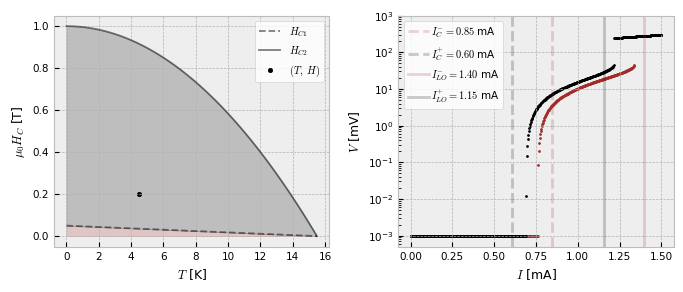

In [ ]:
# Plot
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
plt.subplots_adjust(wspace=0.25)

# 1st Axis
ax[0].plot(T, μ0*HC1, color='black', linestyle='--', linewidth=lw_, alpha=alp3_, label=f'$H_{{C1}}$')
ax[0].plot(T, μ0*HC2, color='black', linewidth=lw_, alpha=alp3_, label=f'$H_{{C2}}$')
ax[0].scatter(T0, μ0*H0, color='black', s=10, label='$(T, \\ H)$')
ax[0].fill_between(T, μ0*HC1, μ0*HC2, color='black', alpha=alp2_)
ax[0].fill_between(T, 0.0, μ0*HC1, color='brown', alpha=alp2_)
ax[0].set_xlabel('$T$ [K]', fontsize=fs2_); ax[0].set_ylabel('$\\mu_{0}H_{C}$ [T]', fontsize=fs2_)
ax[0].set_xticks(range(0, 17 ,2))
ax[0].legend(loc='upper right', facecolor='white', fontsize=fs1_)

# 2nd Axis
ax[1].scatter(np.abs(1e3*I_n), np.abs(1e3*V_n), color='brown', s=2)
ax[1].scatter(1e3*I_p, 1e3*V_p, color='black', s=2)
ax[1].axvline(1e3*IC_n, color='brown', linestyle='--', alpha=alp2_, label=f'$I_{{C}}^{{-}} = {1e3*IC_n:0.2f} $ mA')
ax[1].axvline(1e3*IC_p, color='black', linestyle='--', alpha=alp2_, label=f'$I_{{C}}^{{+}} = {1e3*IC_p:0.2f} $ mA')
ax[1].axvline(1e3*ILO_n, color='brown', linestyle='-', alpha=alp2_, label=f'$I_{{LO}}^{{-}} = {1e3*ILO_n:0.2f} $ mA')
ax[1].axvline(1e3*ILO_p, color='black', linestyle='-', alpha=alp2_, label=f'$I_{{LO}}^{{+}} = {1e3*ILO_p:0.2f} $ mA')
ax[1].set_xlabel('$I$ [mA]', fontsize=fs2_); ax[1].set_ylabel('$V$ [mV]', fontsize=fs2_)
ax[1].legend(loc='upper left', facecolor='white', handletextpad=0.2, fontsize=fs1_)
ax[1].set_yscale('log'); ax[1].set_ylim([5e-4, 1e+3])

fig.show()

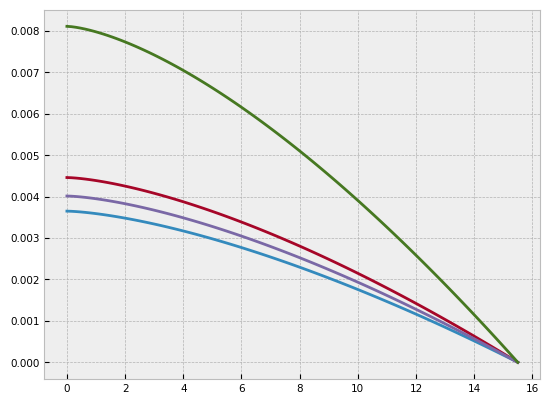

In [ ]:
T  = np.linspace(0.0, params['TC'], 100)
Fp = lambda T, TC: 0.83e-17 * (1 - (T/TC)**1.5)**1
JC_1 = Fp(T, params['TC']) / (φ0 + 0.1*φ0)
JC_2 = Fp(T, params['TC']) / (φ0 - 0.1*φ0)
JC   = Fp(T, params['TC']) / φ0

plt.plot(T, JC_1); plt.plot(T, JC_2); plt.plot(T, JC), ; plt.plot(T, JC_2 + JC_1)

**Mejoras:**

* Forma funcional de la corriente crítica con la temperatura y con el campo magnético.
* La velocidad LO debe ser la misma para ambos sentidos de corriente, en el escenario en que no hay fuerza de anistropía. Esta fuerza lo que hará, es que, los vórtices de muevan más rápido o más lento.

1. Superconductividad
2. Diagrama de Fase
3. Tipo de Superconductores
4. Vórtices de Abrikosov
5. Dinámica de Vórtices
6. Curvas Corriente-Voltaje
7. Inestabilidad de Larkin-Ovchinnikov
8. Extender el Modelo de Dinámica de Vórtices
9. Litografias y cantidad de vórtices